使用已下载文件: ./root/hymenoptera_data.zip


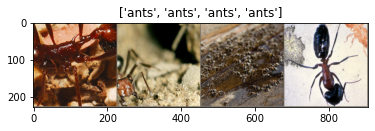

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### 下载图片数据

import os
import os.path
import errno
url ='https://download.pytorch.org/tutorial/hymenoptera_data.zip'
filename='hymenoptera_data.zip'

def download(root):
    '''
    下载数据用于训练和测试的ants和bees的图片压缩包。
    使用zipfile包减压压缩包。    
    '''
    root = os.path.expanduser(root)
    import zipfile
    
    #下载图片压缩包到指定路径
    download_url(url,root,filename)
    
    #获得当前路径
    cwd = os.getcwd()    
    path = os.path.join(root, filename)
    tar = zipfile.ZipFile(path, "r")
    #解压文件
    tar.extractall(root)
    tar.close()
    #切换到当前工作路径
    os.chdir(cwd)

def download_url(url, root, filename):
    from six.moves import urllib
    root = os.path.expanduser(root)
    fpath = os.path.join(root, filename)
    
    try:
        os.makedirs(root)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
    
    # downloads file
    if os.path.isfile(fpath) :
        print('使用已下载文件: ' + fpath)
    else:
        try:
            print('下载 ' + url + ' 到 ' + fpath)
            urllib.request.urlretrieve(url, fpath)
        except:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(url, fpath)

download('./root')

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './root/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
                       

Epoch 0/24
----------


/home/liwh/.conda/envs/dnabert/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6049 Acc: 0.6475
val Loss: 0.2297 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6394 Acc: 0.7377
val Loss: 0.2710 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5561 Acc: 0.7746
val Loss: 0.2379 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5606 Acc: 0.7746
val Loss: 0.2261 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3413 Acc: 0.8566
val Loss: 0.2365 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4685 Acc: 0.8402
val Loss: 0.3305 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4303 Acc: 0.7992
val Loss: 0.2737 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3945 Acc: 0.8197
val Loss: 0.2307 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4072 Acc: 0.8197
val Loss: 0.2151 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2698 Acc: 0.9098
val Loss: 0.2325 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2895 Acc: 0.8934
val Loss: 0.2231 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2923 Acc: 0.9016
val Loss: 0.1921 Acc: 0.9281

Epoch 12/24
----------
t

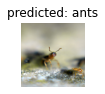

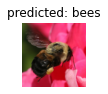

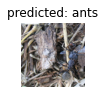

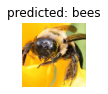

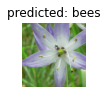

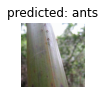

In [8]:
visualize_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/home/liwh/.conda/envs/dnabert/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5248 Acc: 0.7131
val Loss: 0.3072 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5765 Acc: 0.8033
val Loss: 0.2213 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4458 Acc: 0.7992
val Loss: 0.1677 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.4353 Acc: 0.7951
val Loss: 0.1609 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4396 Acc: 0.8074
val Loss: 0.1572 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4209 Acc: 0.8279
val Loss: 0.4279 Acc: 0.8170

Epoch 6/24
----------
train Loss: 0.5200 Acc: 0.7910
val Loss: 0.1581 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3630 Acc: 0.8525
val Loss: 0.1534 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3610 Acc: 0.8525
val Loss: 0.1694 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3946 Acc: 0.8238
val Loss: 0.1573 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3381 Acc: 0.8648
val Loss: 0.1602 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4049 Acc: 0.8361
val Loss: 0.1946 Acc: 0.9412

Epoch 12/24
----------
t